In [0]:
!pip3 install pytorch-nlp
from torchnlp.word_to_vector import GloVe
g_vec = GloVe(name='6B', dim='50')

In [0]:
import numpy as np
import json

train_text = json.load(open('clean_train.json'))
test_text = json.load(open('clean_test.json'))

vocab = np.unique(train_text+test_text)

In [0]:
import json

i_train_text = json.load(open('i_train.json'))
i_test_text = json.load(open('i_test.json'))

In [0]:
v = vocab.shape[0]
d = g_vec['the'].shape[0]

del vocab

In [0]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, h=35, window=4, emb_d=50):
        super(Net, self).__init__()
        self.lin = nn.Linear(window*emb_d, h)
        self.lout = nn.Linear(h, v)
        nn.init.xavier_uniform_(self.lin.weight)
        nn.init.xavier_uniform_(self.lout.weight)

    def forward(self, x):
        x = torch.tanh(self.lin(x))
        x = torch.sigmoid(self.lout(x))
        return x

In [0]:
def shuffle(x, y) :
  index = np.arange(y.shape[0])
  np.random.shuffle(index)
  x = x[index]
  y = y[index]
  return x,y

def data_loader(data, idata, window) :
  l = len(data)
  x = np.array(list(map(lambda i: data[i:i+window], np.arange(l-window))))
  y = np.array(idata[window:])
  return x,y

In [0]:
import torch
import numpy as np
from tqdm.notebook import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

def train_step(net, inputs, labels, optimizer, batch_size) :
    X,Y = shuffle(inputs,labels)
    losses = list()
    for b in range(Y.shape[0]//batch_size+1) :
        x,y = X[b*batch_size : (b+1)*batch_size], Y[b*batch_size : (b+1)*batch_size]
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        loss = float(loss)
        losses.append(loss)
        del x,y
    perplexity = 2**(np.array(losses).mean())
    del X,Y,losses
    return perplexity

def test(net, data, idata, emb, window, d) :
  X,Y = data_loader(data,idata,window)
  X = torch.cat(list(map(lambda x: emb[x.tolist()].reshape(-1), X))).reshape(-1, window*d)
  Y = torch.from_numpy(Y)
  X,Y = X.to(device), Y.to(device)
  perplexity = 0
  with torch.no_grad():
      outputs = net(X)
      loss = criterion(outputs, Y)
      loss = float(loss)
      perplexity = 2**loss
  del X,Y
  return perplexity

def Train(net, data, idata, test_data, test_idata, emb, lr=0.02, window=4, epoch=300, batch_size=10000) :
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    inputs,labels = data_loader(data,idata,window)
    inputs = torch.cat(list(map(lambda x: emb[x.tolist()].reshape(-1), inputs))).reshape(-1, window*d)
    labels = torch.from_numpy(labels)
    turns = trange(epoch, leave=True)
    train_perplexities = list()
    test_perplexities = list()
    for t in turns :
        train_perplexities.append(train_step(net=net, inputs=inputs, labels=labels, optimizer=optimizer, batch_size=batch_size))
        test_perplexities.append(test(net, test_data, test_idata, emb, window, d))
        turns.set_description('train: '+str(int(train_perplexities[-1]))+' | '+'test: '+str(int(test_perplexities[-1])))
    return train_perplexities,test_perplexities

In [0]:
import matplotlib.pyplot as plt
import json

def test_network(hidden_layer, window, learning_rate, epoch, title) :
    net = Net(h=hidden_layer, window=window)
    net.to(device)
    p_train, p_test = Train(net, train_text, i_train_text, test_text, i_test_text , g_vec, epoch=epoch, lr=learning_rate, window=window)
    json.dump(train_text, open(title+'p_train.json','w'))
    json.dump(test_text, open(title+'p_test.json','w'))
    plt.plot(p_train, label='train')
    plt.plot(p_test, label='test')
    plt.ylabel('perplexity')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend()
    plt.show()
    del net

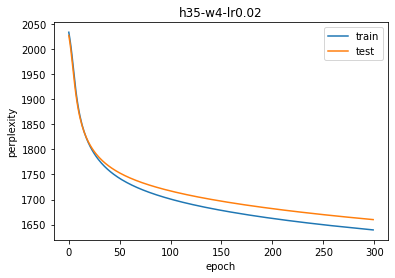

In [9]:
test_network(hidden_layer=35, window=4, learning_rate=0.02, epoch=300, title='h35-w4-lr0.02')
# test_network(hidden_layer=35, window=2, learning_rate=0.02, epoch=300, title='h35-w2-lr0.02')
# test_network(hidden_layer=35, window=3, learning_rate=0.02, epoch=300, title='h35-w3-lr0.02')
# test_network(hidden_layer=35, window=4, learning_rate=0.1, epoch=300, title='h35-w4-lr0.1')
# test_network(hidden_layer=35, window=4, learning_rate=0.03, epoch=300, title='h35-w4-lr0.03')
# test_network(hidden_layer=35, window=4, learning_rate=0.01, epoch=300, title='h35-w4-lr0.01')
# test_network(hidden_layer=50, window=4, learning_rate=0.02, epoch=300, title='h50-w4-lr0.02')
# test_network(hidden_layer=100, window=4, learning_rate=0.02, epoch=300, title='h100-w4-lr0.02')
# test_network(hidden_layer=150, window=4, learning_rate=0.02, epoch=300, title='h150-w4-lr0.02')